In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler, OneHotEncoder
import pickle

In [16]:
from tensorflow.keras.utils import to_categorical

def import_and_clean_file(file, file_dir):
    activities = [
    'Ascending stairs', 'Descending stairs', 'Lying down back', 'Lying down on left',
    'Lying down on stomach', 'Lying down right', 'Miscellaneous movements', 'Normal walking',
    'Running', 'Shuffle walking', 'Sitting', 'Standing'
    ]
    
    # read data from name of file
    sensor, student, activity, activity_subtype, _, date, timestamp = file[:-4].split("_")
    # read in database
    df = pd.read_csv(file_dir)
    # drop features we dont want
    df = df.drop(['ind', 'mag_x','mag_y','mag_z', 'gyro_x','gyro_y','gyro_z'], axis = 1, errors = 'ignore')
    scale_columns = ['accel_x', 'accel_y', 'accel_z']
    df['timestamp'] = df['timestamp'].astype(np.float64)
#     df['accel_x'] = df['accel_x'].astype(np.float64)
#     df['accel_y'] = df['accel_y'].astype(np.float64)
#     df['accel_z'] = df['accel_z'].astype(np.float64)
#     df['gyro_x'] = df['gyro_x'].astype(np.float64)
#     df['gyro_y'] = df['gyro_y'].astype(np.float64)
#     df['gyro_z'] = df['gyro_z'].astype(np.float64)
    df['activity'] = activities.index(activity)
    df['activity'] = df['activity'].astype(np.float64)
    df['activity_subtype'] = activity_subtype
    df.sort_values(by=['timestamp'])
    # scale data
    
    return df

In [17]:
from scipy import stats
# Create a DataFrame with a single column for activities


def get_X_y(directory='/Users/apple/Library/Mobile Documents/com~apple~CloudDocs/Year 3/Final-Project/0 Modules/IoT/PDIoT-cw3-q1/Models/Respeck', window_size=25, overlap=10):
    # Initialize lists to store data and labels
    X = []  # Data
    y = []  # Labels



    # Loop through the clean-named subfolders
    for student in os.listdir(directory):
            if "placeholder" not in student:
                student_directory = os.path.join(directory, student)
                # itterate through students data
                for file in os.listdir(student_directory):
                    file_dir = os.path.join(student_directory, file)
                    if os.path.isfile(file_dir) and "clean" in file and "Respeck" in file:
                        sensor, student, activity, activity_subtype, _, date, timestamp = file[:-4].split("_")
                        df = import_and_clean_file(file, file_dir)
                        # Split the time series data into overlapping windows
                        for i in range(0, len(df) - window_size + 1, overlap):
                            window = df[i:i + window_size]
                            # create X matrix
                            X.append(window.drop(columns=['timestamp', 'activity_subtype']))
                            # create y matrix
                            y.append(activity_subtype)

    return np.array(X), np.array(y).reshape(-1,1)

In [18]:
output_directory = "/Users/apple/Library/Mobile Documents/com~apple~CloudDocs/Year 3/Final-Project/0 Modules/IoT/CW3/dataset"
# Make sure the directory exists, create it if it does not
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

In [19]:
X,y = get_X_y()
X_file_path = os.path.join(output_directory, 'X_respeck_subtype')
file = open(X_file_path, 'wb')
pickle.dump(X, file)
file.close()
y_file_path = os.path.join(output_directory, 'y_respeck_subtype')
file = open(y_file_path, 'wb')
pickle.dump(y, file)
file.close()

In [118]:
X, y = get_X_y()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape, y_train.shape)

pd.DataFrame(X_train[0]).head()

(7819, 25, 4) (7819, 1)


,0,1,2,3
0,0.164551,0.117126,-0.936585,4.0
1,0.156738,0.110046,-0.939514,4.0
2,0.163818,0.119080,-0.946594,4.0
3,0.159912,0.109558,-0.943665,4.0
4,0.158203,0.115906,-0.941711,4.0


In [119]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)
y_train = enc.transform(y_train)
enc = enc.fit(y_val)
y_val = enc.transform(y_val)

# enc = enc.fit(y_test)
# y_test = enc.transform(y_test)
print(X_train.shape, y_train.shape)

(7819, 25, 4) (7819, 7)


C:\Users\daniel cooper\anaconda3\envs\pdiot\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\daniel cooper\anaconda3\envs\pdiot\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [120]:
model = keras.Sequential()
model.add(keras.layers.Normalization())
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [121]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/100
220/220 [==============================] - 8s 20ms/step - loss: 1.7120 - accuracy: 0.2716 - val_loss: 1.6320 - val_accuracy: 0.2621
Epoch 2/100
220/220 [==============================] - 4s 16ms/step - loss: 1.6217 - accuracy: 0.2835 - val_loss: 1.5860 - val_accuracy: 0.2558
Epoch 3/100
220/220 [==============================] - 3s 16ms/step - loss: 1.5842 - accuracy: 0.2942 - val_loss: 1.5776 - val_accuracy: 0.3056
Epoch 4/100
220/220 [==============================] - 3s 16ms/step - loss: 1.5896 - accuracy: 0.2845 - val_loss: 1.5809 - val_accuracy: 0.2877
Epoch 5/100
220/220 [==============================] - 3s 16ms/step - loss: 1.5860 - accuracy: 0.2973 - val_loss: 1.5972 - val_accuracy: 0.2775
Epoch 6/100
220/220 [==============================] - 3s 16ms/step - loss: 1.5670 - accuracy: 0.3133 - val_loss: 1.5903 - val_accuracy: 0.2864
Epoch 7/100
220/220 [==============================] - 4s 17ms/step - loss: 1.5316 - accuracy: 0.3281 - val_loss: 1.4811 - val_accuracy:

220/220 [==============================] - 4s 16ms/step - loss: 0.4572 - accuracy: 0.8174 - val_loss: 0.4684 - val_accuracy: 0.8069
Epoch 58/100
220/220 [==============================] - 3s 16ms/step - loss: 0.4494 - accuracy: 0.8174 - val_loss: 0.5107 - val_accuracy: 0.7967
Epoch 59/100
220/220 [==============================] - 3s 16ms/step - loss: 0.4489 - accuracy: 0.8188 - val_loss: 0.4605 - val_accuracy: 0.8095
Epoch 60/100
220/220 [==============================] - 4s 16ms/step - loss: 0.4570 - accuracy: 0.8151 - val_loss: 0.4721 - val_accuracy: 0.8120
Epoch 61/100
220/220 [==============================] - 3s 16ms/step - loss: 0.4326 - accuracy: 0.8239 - val_loss: 0.4506 - val_accuracy: 0.8299
Epoch 62/100
220/220 [==============================] - 3s 16ms/step - loss: 0.4462 - accuracy: 0.8208 - val_loss: 0.4353 - val_accuracy: 0.8325
Epoch 63/100
220/220 [==============================] - 4s 16ms/step - loss: 0.4546 - accuracy: 0.8221 - val_loss: 0.3851 - val_accuracy: 0.851

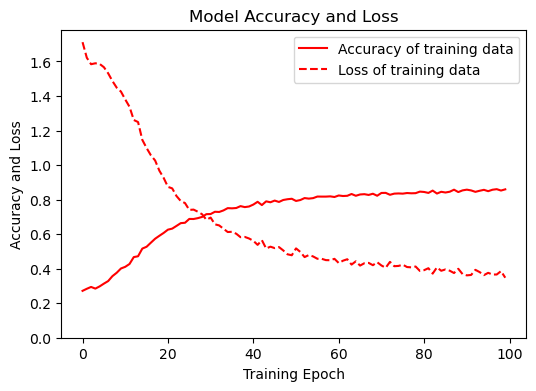

In [122]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()



31/31 [==============================] - 1s 5ms/step


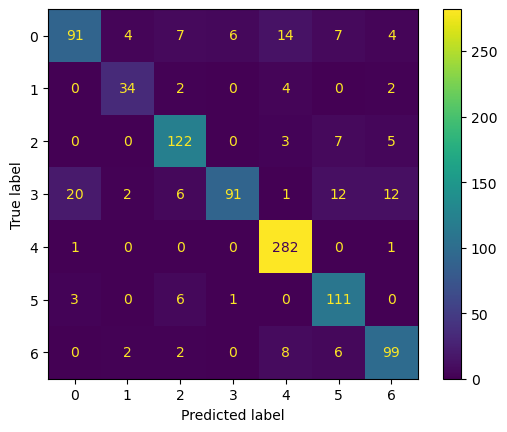

In [123]:
predictions = model.predict(X_val)
predictions = np.argmax(predictions, axis=1)
y_val_pred = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_val_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [124]:
print(classification_report(y_val_pred, predictions))

              precision    recall  f1-score   support

           0       0.79      0.68      0.73       133
           1       0.81      0.81      0.81        42
           2       0.84      0.89      0.87       137
           3       0.93      0.63      0.75       144
           4       0.90      0.99      0.95       284
           5       0.78      0.92      0.84       121
           6       0.80      0.85      0.83       117

    accuracy                           0.85       978
   macro avg       0.84      0.82      0.82       978
weighted avg       0.85      0.85      0.84       978



In [125]:
model.evaluate(X_val, y_val)

31/31 [==============================] - 0s 6ms/step - loss: 0.3628 - accuracy: 0.8487


[0.3628159165382385, 0.8486707806587219]

In [126]:
[name[3:] for name in enc.get_feature_names_out()]

['Coughing',
 'Eating',
 'Hyperventilating',
 'Laughing',
 'Normal',
 'Singing',
 'Talking']

In [127]:

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open('C:/Users/Public/model_subactivities.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\DANIEL~1\AppData\Local\Temp\tmp5_0le3d3\assets


INFO:tensorflow:Assets written to: C:\Users\DANIEL~1\AppData\Local\Temp\tmp5_0le3d3\assets
